In [ ]:
import os
import cv2
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3, EfficientNetB0, ResNet50, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class_folders = sorted(os.listdir('/content/drive/MyDrive/Jordan Archaeological Sites'))
target_size = (224, 224)
SEED = 42
BATCH_SIZE = 32
BUFFER_SIZE = 1024
AUTOTUNE = tf.data.experimental.AUTOTUNE

Image Processor

In [ ]:

class ImageProcessor:

    @staticmethod
    def augment_images(images):
        datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )

        augmented_images = []
        for img in images:
            img = img.reshape((1,) + img.shape)
            for batch in datagen.flow(img, batch_size=1):
                augmented_images.append(batch[0])
                break

        return np.array(augmented_images)

Data Loader

In [ ]:
class DataLoader:

    @staticmethod
    def read_and_resize_images(folder_path, label, target_shape=(224, 224)):
        images = []
        labels = []

        for filename in os.listdir(folder_path):
            if filename.endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(folder_path, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, target_shape)
                    if img.shape[:2] == target_shape:
                        images.append(img)
                        labels.append(label)

        num_images = len(images)
        print(f"Loaded {num_images} images for class {label} from folder {folder_path}")
        return images, labels

    @staticmethod
    def load_dataset(root_folder):
        all_images = []
        all_labels = []
        class_folders = sorted(os.listdir(root_folder))

        for label, class_folder in enumerate(class_folders):
            class_path = os.path.join(root_folder, class_folder)
            if os.path.isdir(class_path):
                images, labels = DataLoader.read_and_resize_images(class_path, label)
                all_images.extend(images)
                all_labels.extend(labels)

        return class_folders, np.array(all_images), np.array(all_labels)

    @staticmethod
    def plot_images(images, labels, class_folders):
        num_classes = len(class_folders)
        fig, axes = plt.subplots(1, num_classes, figsize=(15, 3))

        for i in range(num_classes):
            class_images = images[labels == i]
            axes[i].imshow(class_images[0][:, :, ::-1])
            axes[i].set_title(f" {class_folders[i]}")
            axes[i].axis('off')

        plt.show()

    @staticmethod
    def split_dataset(images, labels, batch_size, seed=42, validation_size=0.2):
        # Split dataset into training and validation sets
        train_images, val_images, train_labels, val_labels = train_test_split(
            images, labels, test_size=validation_size, random_state=seed)

        # Augment the training images
        #augmented_images = ImageProcessor.augment_images(images)

        # Combine original and augmented data
        #combined_train_images = np.concatenate((images, augmented_images), axis=0)
       # combined_train_labels = np.concatenate((labels, labels), axis=0)
        #print("Total number of data after augmentation:", len(train_labels))
        # Create tf.data.Dataset for training and validation
        train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
        val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

        # Shuffle and batch the training dataset, and prefetch it for better performance
        train_dataset = train_dataset.shuffle(buffer_size=len(train_images), seed=seed).batch(batch_size).prefetch(AUTOTUNE)

        # Batch the validation dataset, and prefetch it
        val_dataset = val_dataset.batch(batch_size).prefetch(AUTOTUNE)

        return train_dataset, val_dataset

In [ ]:
class ModelTrainer:

    @staticmethod
    def build_model_VGG(base_model, num_classes):
        # Freeze the base model layers
        for layer in base_model.layers:
            layer.trainable = False

        # Create a custom model on top of the pre-trained base
        model = models.Sequential()
        model.add(base_model)
        model.add(layers.Flatten())
        model.add(layers.Dense(256, activation='relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(num_classes, activation='softmax'))

        return model
    @staticmethod
    def build_model_inception(base_model, num_classes):
        # Freeze the base model layers
        for layer in base_model.layers:
            layer.trainable = False

        # Create a custom model on top of the pre-trained base
        model = models.Sequential()
        model.add(base_model)
        model.add(layers.GlobalAveragePooling2D())  # Alternative to Flatten
        model.add(layers.Dense(256, activation='relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(num_classes, activation='softmax'))

        return model

    @staticmethod
    def build_model_resnet50(base_model, num_classes):
        # Freeze the base model layers
        for layer in base_model.layers:
            layer.trainable = False

        # Create a custom model on top of the pre-trained base
        model = models.Sequential()
        model.add(base_model)
        model.add(layers.GlobalAveragePooling2D())  # Alternative to Flatten
        model.add(layers.Dense(256, activation='relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(num_classes, activation='softmax'))

        return model
    @staticmethod
    def build_model_efficientnet(base_model, num_classes):
        # Freeze the base model layers
        for layer in base_model.layers:
            layer.trainable = False

        # Create a custom model on top of the pre-trained base
        model = models.Sequential()
        model.add(base_model)
        model.add(layers.GlobalAveragePooling2D())  # Alternative to Flatten
        model.add(layers.Dense(256, activation='relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(num_classes, activation='softmax'))

        return model

    @staticmethod
    def compile_model(model):
        # Compile the model
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model

    @staticmethod
    def train_model(model, train_dataset, val_dataset, epochs=200,early_stopping_patience=150,
                    checkpoint_path='best_weights.h5'):
        # Train the model using tf.data.Dataset
        # Early stopping callback
        early_stopping = None
        if early_stopping_patience:
            early_stopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=early_stopping_patience,
                restore_best_weights=True
            )
        # ModelCheckpoint callback to save the best weights
        model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
            checkpoint_path,
            monitor='val_loss',
            save_best_only=True,
            mode='min',
            verbose=1
        )
        # Train the model using tf.data.Dataset
        history = model.fit(train_dataset,epochs=epochs,validation_data=val_dataset,
            callbacks=[early_stopping, model_checkpoint] if early_stopping else [model_checkpoint],
            verbose=1)


        return model, history

    @staticmethod
    def plot_history(history):
        # Plotting losses and accuracy
        plt.figure(figsize=(12, 4))

        # Plot training & validation accuracy values
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(['Train', 'Test'], loc='upper left')

        # Plot training & validation loss values
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(['Train', 'Test'], loc='upper left')

        plt.tight_layout()
        plt.show()

    @staticmethod
    def save_model(model, file_path='saved_model.h5'):
        # Save the model
        model.save(file_path)
        return model

    @staticmethod
    def load_model(file_path='saved_model.h5'):
        # Load the saved model
        loaded_model = tf.keras.models.load_model(file_path)
        return loaded_model

    def load_best_weights(model, weights_path="best_weights.h5"):
        model.load_weights(weights_path)
        return model

    @staticmethod
    def evaluate_model(loaded_model, val_dataset):
        # Evaluate the loaded model
        eval_result = loaded_model.evaluate(val_dataset)
        print("Loaded Model - Loss: {}, Accuracy: {}".format(eval_result[0], eval_result[1]))

    @staticmethod
    def predict_with_model(loaded_model, sample_image_path, target_size):
        # Make predictions using the loaded model
        img = tf.keras.preprocessing.image.load_img(sample_image_path, target_size=target_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)
        img_array /= 255.0

        predictions = loaded_model.predict(img_array)
        predicted_class = tf.argmax(predictions[0]).numpy()
        plt.figure(figsize=(2, 2))
        plt.imshow(img_array[0][:, :, ::-1])
        print("Predicted Class:", predicted_class)

        for i, class_name in enumerate(class_folders):
            class_probability = predictions[0, i]
            print(f"{class_name}: {class_probability:.4f}")





# VGG

Loaded 516 images for class 0 from folder /content/drive/MyDrive/Jordan Archaeological Sites/Ajloun Castle
Loaded 516 images for class 1 from folder /content/drive/MyDrive/Jordan Archaeological Sites/Jeresh
Loaded 500 images for class 2 from folder /content/drive/MyDrive/Jordan Archaeological Sites/Petra
Loaded 537 images for class 3 from folder /content/drive/MyDrive/Jordan Archaeological Sites/Roman amphitheater
Loaded 502 images for class 4 from folder /content/drive/MyDrive/Jordan Archaeological Sites/Umm_Qais
Loaded 504 images for class 5 from folder /content/drive/MyDrive/Jordan Archaeological Sites/Wadi_Rum


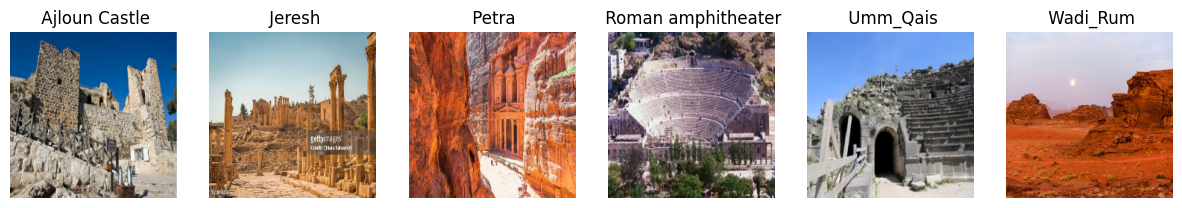

Epoch 1/200
77/77 [==============================] - ETA: 0s - loss: 6.4322 - accuracy: 0.7963
Epoch 1: val_loss improved from inf to 0.43139, saving model to VGG16_best_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


77/77 [==============================] - 14s 169ms/step - loss: 6.4322 - accuracy: 0.7963 - val_loss: 0.4314 - val_accuracy: 0.9366
Epoch 2/200
77/77 [==============================] - ETA: 0s - loss: 0.7113 - accuracy: 0.9098
Epoch 2: val_loss improved from 0.43139 to 0.32545, saving model to VGG16_best_weights.h5
77/77 [==============================] - 13s 171ms/step - loss: 0.7113 - accuracy: 0.9098 - val_loss: 0.3255 - val_accuracy: 0.9577
Epoch 3/200
77/77 [==============================] - ETA: 0s - loss: 0.4227 - accuracy: 0.9337
Epoch 3: val_loss improved from 0.32545 to 0.27123, saving model to VGG16_best_weights.h5
77/77 [==============================] - 14s 179ms/step - loss: 0.4227 - accuracy: 0.9337 - val_loss: 0.2712 - val_accuracy: 0.9496
Epoch 4/200
77/77 [==============================] - ETA: 0s - loss: 0.3355 - accuracy: 0.9435
Epoch 4: val_loss improved from 0.27123 to 0.26069, saving model to VGG16_best_weights.h5
77/77 [==============================] - 14s 176m

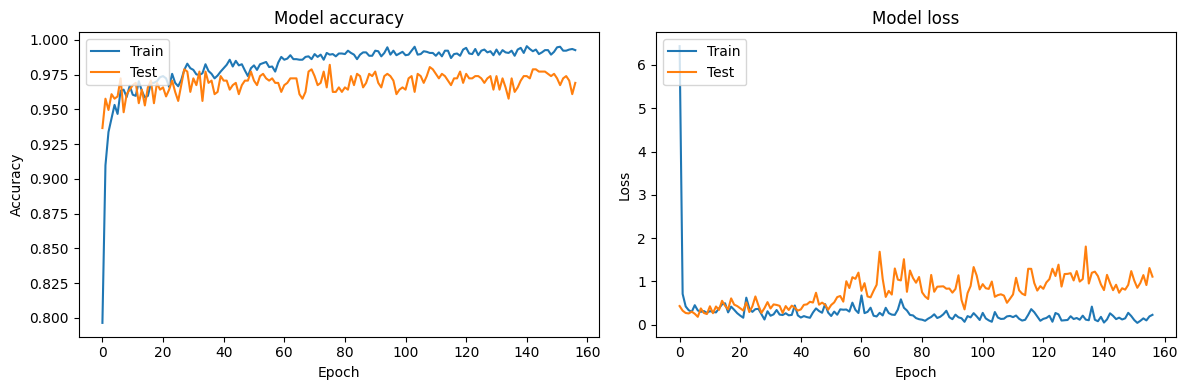

Loaded Model: <keras.src.engine.sequential.Sequential object at 0x7c162d48fdf0>
20/20 [==============================] - 3s 127ms/step - loss: 0.1826 - accuracy: 0.9724
Loaded Model - Loss: 0.18262268602848053, Accuracy: 0.9723577499389648
20/20 [==============================] - 3s 128ms/step - loss: 0.1826 - accuracy: 0.9724
Loaded Model - Loss: 0.18262268602848053, Accuracy: 0.9723577499389648
1/1 [==============================] - 0s 147ms/step
Predicted Class: 3
Ajloun Castle: 0.0394
Jeresh: 0.0104
Petra: 0.0583
Roman amphitheater: 0.4292
Umm_Qais: 0.3939
Wadi_Rum: 0.0689
1/1 [==============================] - 0s 154ms/step
Predicted Class: 3
Ajloun Castle: 0.0394
Jeresh: 0.0104
Petra: 0.0583
Roman amphitheater: 0.4292
Umm_Qais: 0.3939
Wadi_Rum: 0.0689


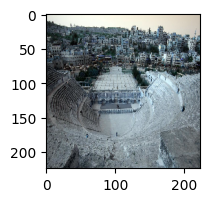

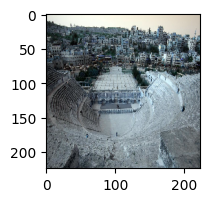

In [ ]:
class Application_VGG16:

    @staticmethod
    def run(root_folder='/content/drive/MyDrive/Jordan Archaeological Sites' ,
             target_size=(224, 224),batch_size=32, epochs=5):
        # Step 1: Load and preprocess data
        data_loader = DataLoader()
        class_folders, images, labels = data_loader.load_dataset(root_folder)
        data_loader.plot_images(images, labels, class_folders)

        # Step 3: Split dataset into training, validation
        train_dataset, val_dataset = DataLoader.split_dataset(images, labels, BATCH_SIZE, seed=SEED)


        # Step 7: Model training using VGG16
        vgg_base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        custom_model = ModelTrainer.build_model(vgg_base_model, len(class_folders))
        compiled_model = ModelTrainer.compile_model(custom_model)
        trained_model, history = ModelTrainer.train_model(compiled_model, train_dataset, val_dataset,
                                                           epochs=200,early_stopping_patience=150, checkpoint_path='VGG16_best_weights.h5')
        ModelTrainer.plot_history(history)

        trained_model=  ModelTrainer.save_model(trained_model, 'vgg_model.h5')

        loaded_model = ModelTrainer.load_model('vgg_model.h5')
        best_model=ModelTrainer.load_best_weights(trained_model,'/content/VGG16_best_weights.h5')

        # Print the loaded model
        print("Loaded Model:", loaded_model)
        ModelTrainer.evaluate_model(loaded_model, val_dataset)
        ModelTrainer.evaluate_model(best_model, val_dataset)
        sample_image_path = '/content/0_2.jpg'
        ModelTrainer.predict_with_model(loaded_model, sample_image_path, target_size=(224, 224))
        ModelTrainer.predict_with_model(best_model, sample_image_path, target_size=(224, 224))






if __name__ == "__main__":
    Application_VGG16.run()


# InceptionV3

Loaded 516 images for class 0 from folder /content/drive/MyDrive/Jordan Archaeological Sites/Ajloun Castle
Loaded 516 images for class 1 from folder /content/drive/MyDrive/Jordan Archaeological Sites/Jeresh
Loaded 500 images for class 2 from folder /content/drive/MyDrive/Jordan Archaeological Sites/Petra
Loaded 537 images for class 3 from folder /content/drive/MyDrive/Jordan Archaeological Sites/Roman amphitheater
Loaded 502 images for class 4 from folder /content/drive/MyDrive/Jordan Archaeological Sites/Umm_Qais
Loaded 504 images for class 5 from folder /content/drive/MyDrive/Jordan Archaeological Sites/Wadi_Rum


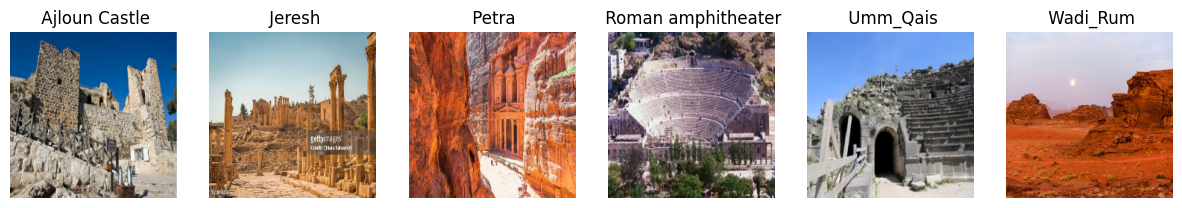

87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/200
77/77 [==============================] - ETA: 0s - loss: 7.8294 - accuracy: 0.1927
Epoch 1: val_loss improved from inf to 1.77979, saving model to InceptionV3_best_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


77/77 [==============================] - 26s 187ms/step - loss: 7.8294 - accuracy: 0.1927 - val_loss: 1.7798 - val_accuracy: 0.2114
Epoch 2/200
77/77 [==============================] - ETA: 0s - loss: 1.7932 - accuracy: 0.1581
Epoch 2: val_loss did not improve from 1.77979
77/77 [==============================] - 6s 78ms/step - loss: 1.7932 - accuracy: 0.1581 - val_loss: 1.7833 - val_accuracy: 0.1642
Epoch 3/200
77/77 [==============================] - ETA: 0s - loss: 1.7915 - accuracy: 0.1760
Epoch 3: val_loss did not improve from 1.77979
77/77 [==============================] - 6s 81ms/step - loss: 1.7915 - accuracy: 0.1760 - val_loss: 1.7843 - val_accuracy: 0.1724
Epoch 4/200
77/77 [==============================] - ETA: 0s - loss: 1.7900 - accuracy: 0.1825
Epoch 4: val_loss did not improve from 1.77979
77/77 [==============================] - 6s 82ms/step - loss: 1.7900 - accuracy: 0.1825 - val_loss: 1.7835 - val_accuracy: 0.1707
Epoch 5/200
77/77 [==============================] -

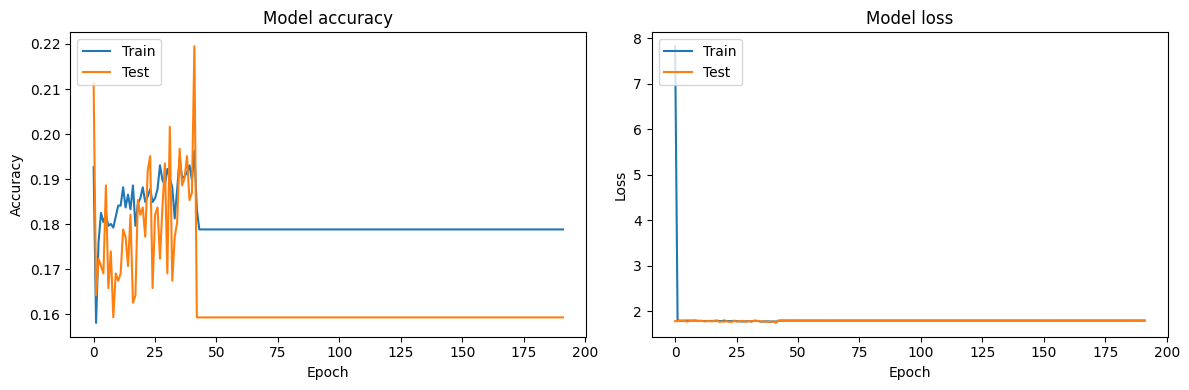

Loaded Model: <keras.src.engine.sequential.Sequential object at 0x79dd3c526830>
20/20 [==============================] - 3s 66ms/step - loss: 1.7418 - accuracy: 0.2195
Loaded Model - Loss: 1.741835355758667, Accuracy: 0.2195121943950653
20/20 [==============================] - 1s 64ms/step - loss: 1.7418 - accuracy: 0.2195
Loaded Model - Loss: 1.741835355758667, Accuracy: 0.2195121943950653
1/1 [==============================] - 3s 3s/step
Predicted Class: 2
Ajloun Castle: 0.1633
Jeresh: 0.1700
Petra: 0.2403
Roman amphitheater: 0.1806
Umm_Qais: 0.1190
Wadi_Rum: 0.1269
1/1 [==============================] - 3s 3s/step
Predicted Class: 2
Ajloun Castle: 0.1570
Jeresh: 0.1617
Petra: 0.3123
Roman amphitheater: 0.1731
Umm_Qais: 0.0929
Wadi_Rum: 0.1029


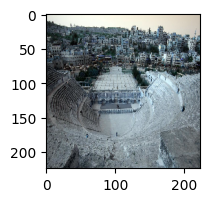

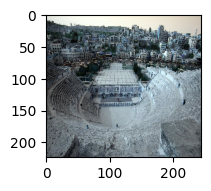

In [ ]:
class Application_InceptionV3:

    @staticmethod
    def run(root_folder='/content/drive/MyDrive/Jordan Archaeological Sites',
            target_size=(224, 224), batch_size=32, epochs=5):
        # Step 1: Load and preprocess data
        data_loader = DataLoader()
        class_folders, images, labels = data_loader.load_dataset(root_folder)
        data_loader.plot_images(images, labels, class_folders)

        # Step 3: Split dataset into training, validation
        train_dataset, val_dataset = DataLoader.split_dataset(images, labels, BATCH_SIZE, seed=SEED)

        # Step 7: Model training using InceptionV3
        inception_base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        custom_model = ModelTrainer.build_model_inception(inception_base_model, len(class_folders))
        compiled_model = ModelTrainer.compile_model(custom_model)
        trained_model, history = ModelTrainer.train_model(compiled_model, train_dataset, val_dataset,
                                                           epochs=200, early_stopping_patience=150,
                                                           checkpoint_path='InceptionV3_best_weights.h5')
        ModelTrainer.plot_history(history)

        trained_model = ModelTrainer.save_model(trained_model, 'inception_model.h5')

        loaded_model = ModelTrainer.load_model('inception_model.h5')
        best_model = ModelTrainer.load_best_weights(loaded_model, 'InceptionV3_best_weights.h5')

        # Print the loaded model
        print("Loaded Model:", loaded_model)
        ModelTrainer.evaluate_model(loaded_model, val_dataset)
        ModelTrainer.evaluate_model(best_model, val_dataset)
        sample_image_path = '/content/0_2.jpg'
        ModelTrainer.predict_with_model(loaded_model, sample_image_path, target_size=(224, 224))
        ModelTrainer.predict_with_model(best_model, sample_image_path, target_size=(224, 224))


if __name__ == "__main__":
    Application_InceptionV3.run()


##ResNet50

Loaded 516 images for class 0 from folder /content/drive/MyDrive/Jordan Archaeological Sites/Ajloun Castle
Loaded 516 images for class 1 from folder /content/drive/MyDrive/Jordan Archaeological Sites/Jeresh
Loaded 500 images for class 2 from folder /content/drive/MyDrive/Jordan Archaeological Sites/Petra
Loaded 537 images for class 3 from folder /content/drive/MyDrive/Jordan Archaeological Sites/Roman amphitheater
Loaded 502 images for class 4 from folder /content/drive/MyDrive/Jordan Archaeological Sites/Umm_Qais
Loaded 504 images for class 5 from folder /content/drive/MyDrive/Jordan Archaeological Sites/Wadi_Rum


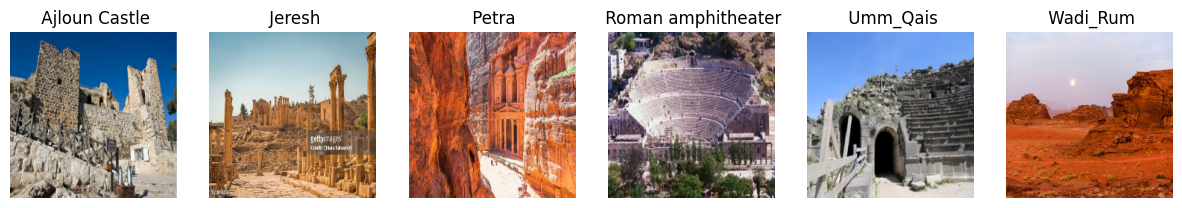

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_12 (Dense)            (None, 256)               524544    
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                      

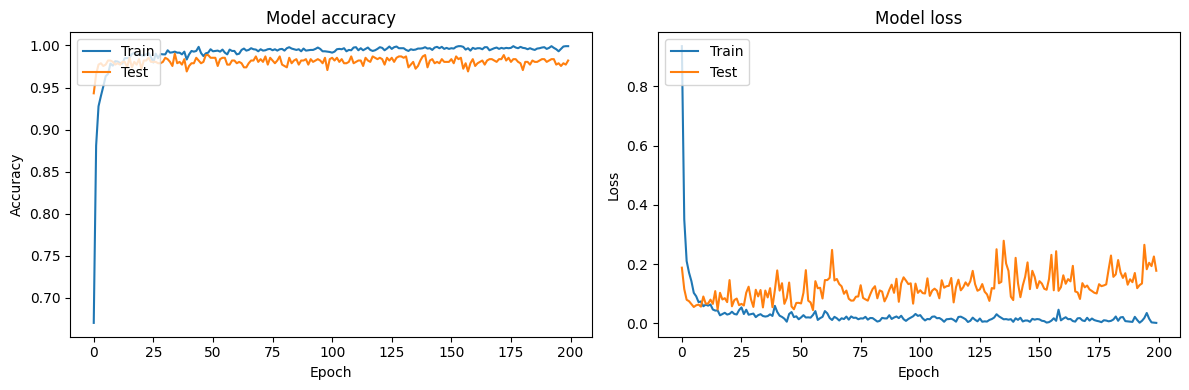

Loaded Model: <keras.src.engine.sequential.Sequential object at 0x79dd67f2f3d0>
20/20 [==============================] - 3s 86ms/step - loss: 0.0450 - accuracy: 0.9854
Loaded Model - Loss: 0.04500049352645874, Accuracy: 0.9853658676147461

Best Model: <keras.src.engine.sequential.Sequential object at 0x79dd67f2f3d0>
20/20 [==============================] - 2s 88ms/step - loss: 0.0450 - accuracy: 0.9854
Loaded Model - Loss: 0.04500049352645874, Accuracy: 0.9853658676147461
1/1 [==============================] - 2s 2s/step
Predicted Class: 5
Ajloun Castle: 0.0050
Jeresh: 0.0011
Petra: 0.0053
Roman amphitheater: 0.0310
Umm_Qais: 0.0182
Wadi_Rum: 0.9394


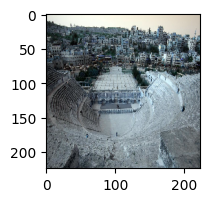

In [ ]:
class Application_ResNet50:

    @staticmethod
    def run(root_folder='/content/drive/MyDrive/Jordan Archaeological Sites' ,
             target_size=(224, 224),batch_size=32, epochs=5):
        # Step 1: Load and preprocess data
        data_loader = DataLoader()
        class_folders, images, labels = data_loader.load_dataset(root_folder)
        data_loader.plot_images(images, labels, class_folders)
        # Step 2: Split dataset into training, validation
        train_dataset, val_dataset = DataLoader.split_dataset(images, labels, BATCH_SIZE, seed=SEED)

        # Step 6: Model training using ResNet50
        resnet_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

        custom_model = ModelTrainer.build_model_resnet50(resnet_base_model, len(class_folders))
        compiled_model = ModelTrainer.compile_model(custom_model)
        compiled_model.summary()
        trained_model, history = ModelTrainer.train_model(compiled_model, train_dataset, val_dataset,
                                                           epochs=200, early_stopping_patience=150,
                                                           checkpoint_path='resnet50_best_weights.h5')


        ModelTrainer.plot_history(history)
        trained_model= ModelTrainer.save_model(trained_model, 'resnet_model.h5')
        loaded_model = ModelTrainer.load_model('resnet_model.h5')
        best_model = ModelTrainer.load_best_weights(loaded_model,'resnet50_best_weights.h5')

        # Print the loaded model
        print("Loaded Model:", loaded_model)
        ModelTrainer.evaluate_model(loaded_model, val_dataset)
        print("\nBest Model:", best_model)
        ModelTrainer.evaluate_model(best_model, val_dataset)
        sample_image_path = '/content/0_2.jpg'
        ModelTrainer.predict_with_model(best_model, sample_image_path, target_size=(224, 224))







if __name__ == "__main__":
    Application_ResNet50.run()


##EfficientNetB0

Loaded 516 images for class 0 from folder /content/drive/MyDrive/Jordan Archaeological Sites/Ajloun Castle
Loaded 516 images for class 1 from folder /content/drive/MyDrive/Jordan Archaeological Sites/Jeresh
Loaded 500 images for class 2 from folder /content/drive/MyDrive/Jordan Archaeological Sites/Petra
Loaded 537 images for class 3 from folder /content/drive/MyDrive/Jordan Archaeological Sites/Roman amphitheater
Loaded 502 images for class 4 from folder /content/drive/MyDrive/Jordan Archaeological Sites/Umm_Qais
Loaded 504 images for class 5 from folder /content/drive/MyDrive/Jordan Archaeological Sites/Wadi_Rum


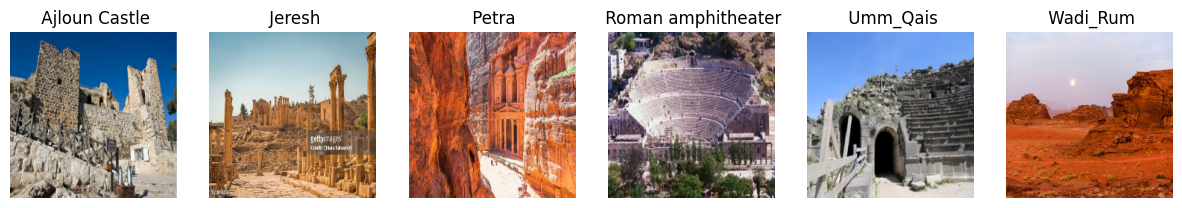

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_6  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_18 (Dense)            (None, 256)               327936    
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_19 (Dense)            (None, 128)               32896     
                                                                 
 dropout_13 (Dropout)        (None, 128)              

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


77/77 [==============================] - 16s 116ms/step - loss: 0.6152 - accuracy: 0.7744 - val_loss: 0.1294 - val_accuracy: 0.9480
Epoch 2/200
76/77 [============================>.] - ETA: 0s - loss: 0.1829 - accuracy: 0.9346
Epoch 2: val_loss improved from 0.12936 to 0.09830, saving model to Efficientnet_best_weights.h5
77/77 [==============================] - 6s 76ms/step - loss: 0.1813 - accuracy: 0.9354 - val_loss: 0.0983 - val_accuracy: 0.9626
Epoch 3/200
76/77 [============================>.] - ETA: 0s - loss: 0.1135 - accuracy: 0.9613
Epoch 3: val_loss improved from 0.09830 to 0.04753, saving model to Efficientnet_best_weights.h5
77/77 [==============================] - 6s 79ms/step - loss: 0.1132 - accuracy: 0.9614 - val_loss: 0.0475 - val_accuracy: 0.9837
Epoch 4/200
77/77 [==============================] - ETA: 0s - loss: 0.0715 - accuracy: 0.9764
Epoch 4: val_loss did not improve from 0.04753
77/77 [==============================] - 5s 71ms/step - loss: 0.0715 - accuracy: 0

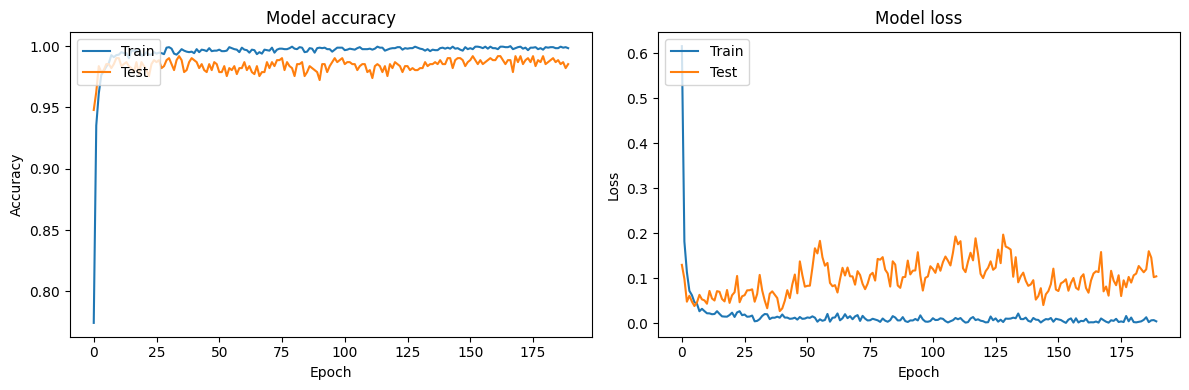

Loaded Model: <keras.src.engine.sequential.Sequential object at 0x79dd69ee57b0>
20/20 [==============================] - 3s 58ms/step - loss: 0.0267 - accuracy: 0.9902
Loaded Model - Loss: 0.026650328189134598, Accuracy: 0.9902439117431641
20/20 [==============================] - 1s 56ms/step - loss: 0.0267 - accuracy: 0.9902
Loaded Model - Loss: 0.026650328189134598, Accuracy: 0.9902439117431641
1/1 [==============================] - 3s 3s/step
Predicted Class: 4
Ajloun Castle: 0.0010
Jeresh: 0.0000
Petra: 0.0000
Roman amphitheater: 0.0011
Umm_Qais: 0.9960
Wadi_Rum: 0.0019


1/1 [==============================] - 2s 2s/step
Predicted Class: 4
Ajloun Castle: 0.0024
Jeresh: 0.0000
Petra: 0.0000
Roman amphitheater: 0.0013
Umm_Qais: 0.9951
Wadi_Rum: 0.0013


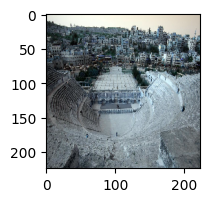

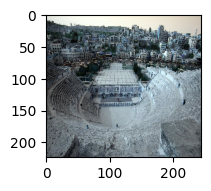

In [ ]:
class Application_EfficientNetB0:

     @staticmethod
     def run(root_folder='/content/drive/MyDrive/Jordan Archaeological Sites' ,
             target_size=(224, 224),batch_size=32):
        # Step 1: Load and preprocess data
        data_loader = DataLoader()
        class_folders, images, labels = data_loader.load_dataset(root_folder)
        data_loader.plot_images(images, labels, class_folders)
        # Step 2: Split dataset into training, validation
        train_dataset, val_dataset = DataLoader.split_dataset(images, labels, BATCH_SIZE, seed=SEED)




      # Step 5: Model training using EfficientNet
        efficientnet_base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        custom_model = ModelTrainer.build_model_efficientnet(efficientnet_base_model, len(class_folders))
        compiled_model = ModelTrainer.compile_model(custom_model)
        compiled_model.summary()
        trained_model, history = ModelTrainer.train_model(compiled_model, train_dataset, val_dataset,
                                                           epochs=200, early_stopping_patience=150,
                                                           checkpoint_path='Efficientnet_best_weights.h5')


        ModelTrainer.plot_history(history)

        trained_model=  ModelTrainer.save_model(trained_model, 'Efficientnet_model.h5')
        loaded_model = ModelTrainer.load_model('Efficientnet_model.h5')
        best_model = ModelTrainer.load_best_weights(loaded_model, 'Efficientnet_best_weights.h5')

        # Print the loaded model
        print("Loaded Model:", loaded_model)
        ModelTrainer.evaluate_model(loaded_model, val_dataset)
        ModelTrainer.evaluate_model(best_model, val_dataset)
        sample_image_path = '/content/0_2.jpg'
        ModelTrainer.predict_with_model(loaded_model, sample_image_path, target_size=(224, 224))
        ModelTrainer.predict_with_model(best_model, sample_image_path, target_size=(224, 244))




if __name__ == "__main__":
    Application_EfficientNetB0.run()


